In [82]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from sp_extension import *

In [83]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all_csvs"

# NAc: #15616F
# mPFC: #FFAF00

In [84]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/p5-240826-091418/Notes.txt
read from t=0s to t=790.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/nn2-250117-085631/Notes.txt
read from t=0s to t=814.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/p2-240523-081105/Notes.txt
read from t=0s to t=788.65s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/nn4-250118-094351/Notes.txt
read from t=0s to t=795.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/n6-240826-094701/Notes.txt
read from t=0s to t=800.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Social_Pref/all/nn1-250117-081652/Notes.txt

In [85]:
bout_definitions = [
    {
        'prefix': 'Subject',
        'introduced': 'Subject Introduced',
        'removed': 'Subject Removed'
    }
]

experiment.group_extract_manual_annotations(bout_definitions,first_only=True)

Processing behaviors for p5-240826-091418...
Processing behaviors for nn2-250117-085631...
Processing behaviors for p2-240523-081105...
Processing behaviors for nn4-250118-094351...
Processing behaviors for n6-240826-094701...
Processing behaviors for nn1-250117-081652...
Processing behaviors for pp7-250118-075659...
Processing behaviors for pp3-250118-064713...
Processing behaviors for p8-240827-075823...
Processing behaviors for nn8-250118-105443...
Processing behaviors for p1-240522-080200...
Processing behaviors for n5-240826-083822...
Processing behaviors for p6-240827-065303...
Processing behaviors for pp5-250117-121543...
Processing behaviors for pp4-250118-072201...
Processing behaviors for nn7-250118-101917...
Processing behaviors for pp8-250118-083250...
Processing behaviors for nn6-250117-101903...
Processing behaviors for p7-240826-102402...
Processing behaviors for pp6-250117-124823...
Processing behaviors for n7-240827-072608...
Processing behaviors for p3-240522-092431..

## Long-Term Bar Graph - Total Investigation Time

In [86]:
def plot_custom_sniff_cup_assignments(
    experiment, 
    assignment_csv_path,
    title="Mean Investigation Time (Long Term Sniff Cups)",
    xlabel="Long Term",
    xlabel_color=None,
    bar_fill=None,             # If None, uses xlabel_color
    bar_edge='black',
    bar_hatch=None,            # e.g. '/' or '//' or '\\'
    figsize=(6, 8),
    pad_inches=0.1,
    save=False,
    save_name=None
):
    """
    For each subject, extracts total investigation time for the sniff cup assigned to 'long_term',
    classifies them as Pref or No_Pref, and plots the mean + individual data points.
    Bar color matches the x-axis label color if not explicitly provided.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    assign_df = pd.read_csv(assignment_csv_path)

    # --- Subject → sniff cup assignment mapping ---
    subject_to_behavior = {}
    for idx, row in assign_df.iterrows():
        subject = str(row['Subject']).strip()
        for cup_col in assign_df.columns:
            if 'sniff cup' in cup_col.lower():
                cup_value = str(row[cup_col]).strip().lower()
                if cup_value == 'long_term':
                    subject_to_behavior[subject] = cup_col.lower()
                    break

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = skipped_empty = skipped_unmatched = skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break
            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key]
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()
            subject_data.append({
                "Subject": trial_name,
                "Total Investigation Time": total_time,
                "Assigned Behavior": target_behavior
            })
            valid_trials += 1
        else:
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for sniff cup assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    # --- Preference classification ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()
    threshold = mean_time + sem_time

    data_df["Preference"] = data_df["Total Investigation Time"].apply(
        lambda t: "Pref" if t > threshold else "No_Pref"
    )

    pref_subjects = data_df[data_df["Preference"] == "Pref"]["Subject"].tolist()
    no_pref_subjects = data_df[data_df["Preference"] == "No_Pref"]["Subject"].tolist()

    print(f"\nPref Subjects ({len(pref_subjects)}): {pref_subjects}")
    print(f"No_Pref Subjects ({len(no_pref_subjects)}): {no_pref_subjects}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # Determine bar color (default to x label color)
    effective_bar_fill = bar_fill if bar_fill is not None else xlabel_color if xlabel_color else '#cccccc'

    ax.bar(
        0, mean_time,
        yerr=sem_time,
        capsize=10,
        color=effective_bar_fill,
        edgecolor=bar_edge,
        hatch=bar_hatch,
        linewidth=3,
        width=0.6
    )

    for _, row in data_df.iterrows():
        subj = row["Subject"]
        time = row["Total Investigation Time"]
        color = "#15616F" if subj.lower().startswith('n') else "#FFAF00" if subj.lower().startswith('p') else "gray"
        ax.plot(0, time, 'o', color=color, markersize=10)

    ax.set_xticks([0])
    ax.set_xticklabels([xlabel], fontsize=30)
    if xlabel_color:
        ax.get_xticklabels()[0].set_color(xlabel_color)

    ax.set_ylabel("Total Time (s)", fontsize=20)
    ax.set_title(title, fontsize=30)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='y', labelsize=30)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()
    return data_df, pref_subjects, no_pref_subjects



Finished processing CSVs.
Fixed trials: 27
Skipped trials: 0

Total trials: 27
Valid trials with matched behavior: 27
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0

Pref Subjects (8): ['p5-240826-091418', 'pp3-250118-064713', 'n5-240826-083822', 'pp4-250118-072201', 'p7-240826-102402', 'n7-240827-072608', 'nn3-250118-090940', 'p4-240523-092600']
No_Pref Subjects (19): ['nn2-250117-085631', 'p2-240523-081105', 'nn4-250118-094351', 'n6-240826-094701', 'nn1-250117-081652', 'pp7-250118-075659', 'p8-240827-075823', 'nn8-250118-105443', 'p1-240522-080200', 'p6-240827-065303', 'pp5-250117-121543', 'nn7-250118-101917', 'pp8-250118-083250', 'nn6-250117-101903', 'pp6-250117-124823', 'p3-240522-092431', 'nn5-250117-093631', 'pp1-250117-110456', 'pp2-250117-113909']


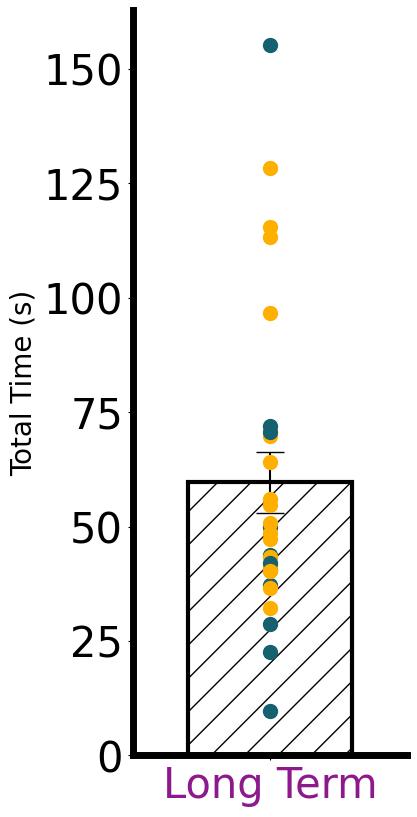

Subjects Pref: ['p5-240826-091418', 'pp3-250118-064713', 'n5-240826-083822', 'pp4-250118-072201', 'p7-240826-102402', 'n7-240827-072608', 'nn3-250118-090940', 'p4-240523-092600']
Subjects No_Pref: ['nn2-250117-085631', 'p2-240523-081105', 'nn4-250118-094351', 'n6-240826-094701', 'nn1-250117-081652', 'pp7-250118-075659', 'p8-240827-075823', 'nn8-250118-105443', 'p1-240522-080200', 'p6-240827-065303', 'pp5-250117-121543', 'nn7-250118-101917', 'pp8-250118-083250', 'nn6-250117-101903', 'pp6-250117-124823', 'p3-240522-092431', 'nn5-250117-093631', 'pp1-250117-110456', 'pp2-250117-113909']


In [87]:
cups = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/Social_Pref_Cup_Assignments.csv"

# Run this before plotting
fix_behavior_data_for_experiment(experiment, csv_base_path)

# Now all experiment.trials[...].behaviors are valid — plot will work!
df_with_pref, pref_list, no_pref_list = plot_custom_sniff_cup_assignments(
    experiment=experiment,
    assignment_csv_path=cups,  # Replace with actual path
    figsize=(4, 8),
    pad_inches=0.1,
    title=None,
    bar_fill='white',             # If None, uses xlabel_color
    bar_edge='black',
    xlabel_color= '#8D1A8D',
    bar_hatch='/', 
    save=None,
    save_name="LongTerm_BarGraph.png"
)


# View results
print("Subjects Pref:", pref_list)
print("Subjects No_Pref:", no_pref_list)

### With colors

In [ ]:
plot_grouped_sniff_cup_assignments(
    experiment=experiment,
    assignment_csv_path=cups,
    bar_color='#cccccc',
    color_nn_pp='red',
    color_n_p='blue',
    figsize=(6, 8),
    title="Cohort Comp: Long Term Cup Investigation",
    pad_inches=0.1,
    save=False,
    save_name="CohortComp_LT_IT.png"
)

## Bimodal Behavior

In [88]:
cups = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/Social_Pref_Cup_Assignments.csv"

# Correct data input
trial_data_with_ids = get_trial_dataframes_with_ids(experiment)

# Create metadata with mapping
metadata_df = create_metadata_dataframe_with_agent_mapping(trial_data_with_ids, sniff_cup_csv_path=cups)

metadata_df

,Total_long_term,Avg_long_term,Total_nothing,Avg_nothing,Total_novel,Avg_novel,Total_short_term,Avg_short_term
Subject,,,,,,,,
p5,128.300,5.578261,42.700,5.337500,48.500,4.041667,51.600,4.690909
nn2,40.400,2.376471,49.900,3.118750,81.199,4.059950,75.699,3.440864
p2,55.932,3.107333,98.998,5.823412,79.063,4.392389,54.731,2.880579
nn4,43.700,3.121429,60.900,2.537500,84.500,6.035714,36.900,3.075000
n6,37.300,3.108333,40.521,5.065125,40.900,3.146154,86.698,5.779867
nn1,9.600,9.600000,93.000,4.043478,55.998,5.090727,35.100,7.020000
pp7,41.300,2.581250,61.400,2.558333,104.899,3.496633,57.500,2.500000
pp3,96.600,3.864000,50.700,4.609091,27.300,5.460000,15.600,3.900000
p8,43.400,3.945455,88.899,5.229353,65.100,4.650000,71.400,5.100000


In [89]:
def plot_investigation_by_agent(df,
                                 subjects_to_include=None,
                                 metric="Total",
                                 title='Investigation Time by Agent (Total)',
                                 ylabel='Investigation Time (s)',
                                 xlabel='Social Agent',
                                 custom_xtick_labels=['Empty', 'Short Term', 'Long Term', 'Novel'],
                                 custom_xtick_colors=['teal', 'blue', 'purple', 'orange'],
                                 ylim=None,
                                 bar_fill_color='white',
                                 bar_edge_color='black',
                                 bar_linewidth=3,
                                 bar_hatch=None,
                                 yticks_increment=None,
                                 figsize=(12, 7),
                                 pad_inches=0.1,
                                 save=False,
                                 legend_loc= "upper right",
                                 save_name=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from scipy.stats import ttest_rel

    df = df.copy()

    if 'Subject' in df.columns:
        df['Subject'] = df['Subject'].astype(str).str.lower()
        df.set_index('Subject', inplace=True)
    else:
        df.index = df.index.astype(str).str.lower()

    if subjects_to_include:
        subjects_to_include = [s.lower() for s in subjects_to_include]
        df = df[df.index.isin(subjects_to_include)]

    agents = ['nothing', 'short_term', 'long_term', 'novel']
    columns_to_plot = [f"{metric}_{agent}" for agent in agents]
    missing_cols = [col for col in columns_to_plot if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Missing columns: {missing_cols}")
        return

    df_plot = df[columns_to_plot].copy()
    df_plot.columns = agents

    if df_plot.empty or df_plot.isnull().all().all():
        print("⚠️ No valid data available to plot.")
        return

    # --- Paired T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "long_term vs nothing": ("long_term", "nothing"),
            "long_term vs short_term": ("long_term", "short_term"),
            "long_term vs novel": ("long_term", "novel")
        }
        results = {}
        for label, (a1, a2) in comparisons.items():
            paired = df_vals[[a1, a2]].dropna()
            if len(paired) > 1:
                t_stat, p_value = ttest_rel(paired[a1], paired[a2])
                results[label] = p_value
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Mean & SEM ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Colored Markers ---
    for subject_id, row in df_plot.iterrows():
        marker_color = '#15616F' if subject_id.startswith('n') else '#FFAF00' if subject_id.startswith('p') else 'gray'
        ax.plot(df_plot.columns, row.values, linestyle='-', color='gray', alpha=0.5, linewidth=2.5, zorder=1)
        ax.scatter(df_plot.columns, row.values, color=marker_color,
                   s=170, alpha=1.0, zorder=1, edgecolors='black', linewidth=2.5)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(df_plot.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df_plot.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=35)
    ax.tick_params(axis='x', labelsize=35)

    # --- Y-limits ---
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Spines ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Region Legend ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
          loc=legend_loc, frameon=True)

    plt.tight_layout(pad=pad_inches)
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()

    # --- Print T-test Results ---
    if t_test_results:
        print("\nPaired t-test results (long term vs others):")
        for comp, p in t_test_results.items():
            if p < 0.001:
                stars = "***"
            elif p < 0.01:
                stars = "**"
            elif p < 0.05:
                stars = "*"
            else:
                stars = "ns"
            print(f"{comp}: p = {p:.4f} ({stars})")


Finished processing CSVs.
Fixed trials: 27
Skipped trials: 0


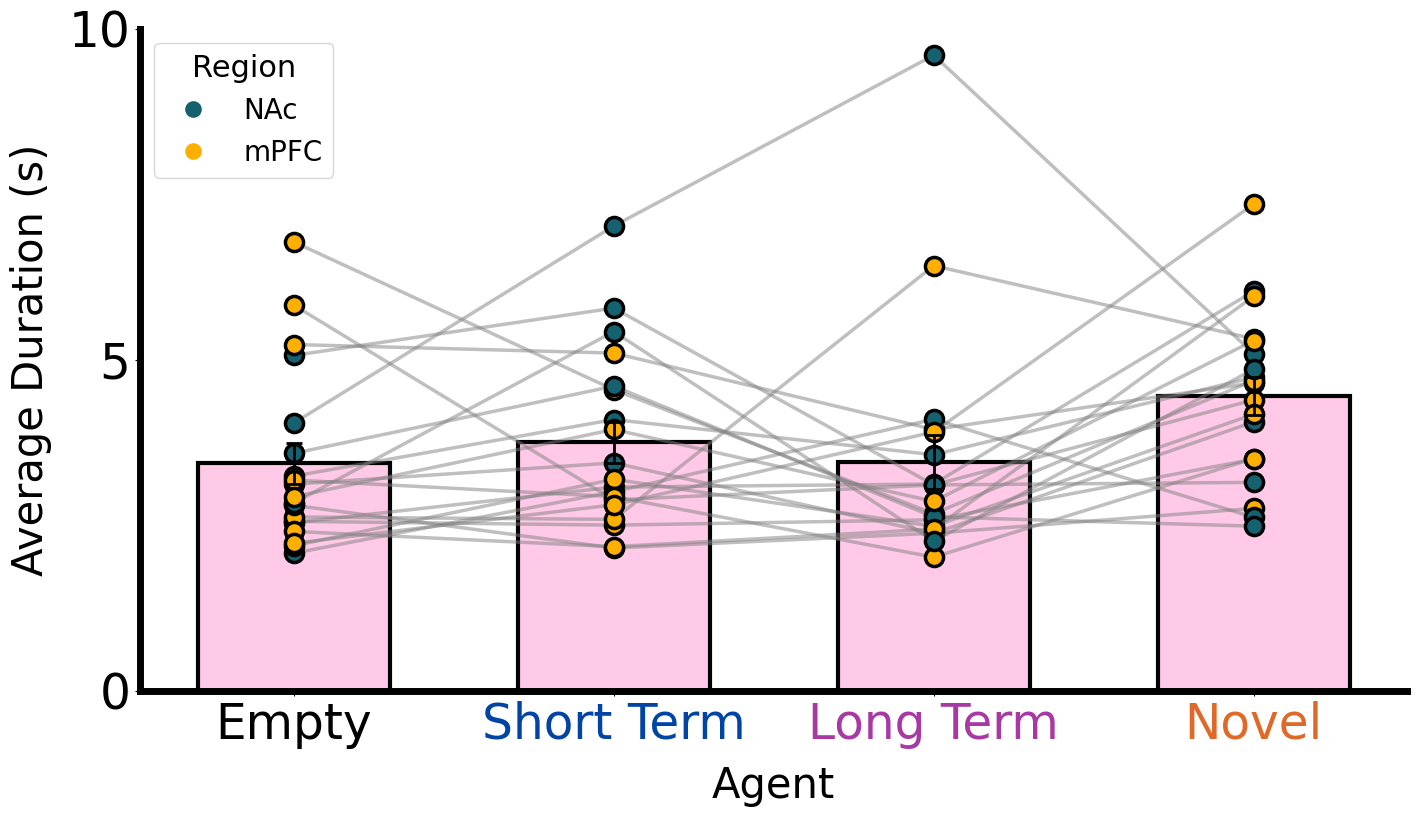


Paired t-test results (long term vs others):
long_term vs nothing: p = 0.9739 (ns)
long_term vs short_term: p = 0.4521 (ns)
long_term vs novel: p = 0.0357 (*)


In [92]:
cups = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/Social_Pref_Cup_Assignments.csv"

# Run this before plotting
fix_behavior_data_for_experiment(experiment, csv_base_path)

# Trim pref_list to match the Subject index
trimmed_pref_list = [s.split('-')[0].lower() for s in no_pref_list]

plot_investigation_by_agent(
    df=metadata_df,                     # Your metadata dataframe
    subjects_to_include=trimmed_pref_list,     # List of Pref subject IDs (full trial names, e.g., 'p5-240826-091418')
    metric="Avg",                    # Choose "Total" or "Avg"
    title=None,
    ylabel="Average Duration (s)",
    xlabel="Agent",
    bar_fill_color='#FFC9E7',
    custom_xtick_labels=["Empty", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["black", "#0045A6", "#A839A4", "#E06928"],          # Optional: match labels to colors
    ylim=(0, 10),                     # Set Y-axis limits if desired
    bar_linewidth=3,
    yticks_increment=5,               # Optional: Y-tick step
    figsize=(14, 8),
    legend_loc = 'upper left',
    pad_inches=0.1,
    save=True,
    save_name="NoPref_ABD.png"
)
#['#A839A4','#E06928','#00B7D7','#0045A6'] 
# pref_list, no_pref_list

## Dopamine Stuff (Need help with this)

In [ ]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)
nonempty_trials = [t.subject_name for t in experiment.trials.values() if not t.behaviors.empty]
print(f"Trials with behavior data: {len(nonempty_trials)} / {len(experiment.trials)}")


experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=5, #total_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')
empty = []
nonempty = []

for trial_id, trial in experiment.trials.items():
    if trial.behaviors.empty:
        empty.append(trial_id)
    else:
        nonempty.append(trial_id)

print(f"Non-empty trials after DA metrics: {len(nonempty)}")
print(f"Empty trials after DA metrics: {len(empty)}")
print("Empty trial names:", empty[:5])  # just the first few

In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a dictionary where:
    - Keys are subject IDs (Trial.subject_name).
    - Values are DataFrames corresponding to the behaviors of each trial.
    """
    trial_data = {}

    for trial in experiment.trials.values():
        subject_id = trial.subject_name  # Extract subject ID
        trial_data[subject_id] = trial.behaviors  # Store behaviors DataFrame

    return trial_data


exp_da_dict = get_trial_dataframes(experiment)
exp_da_dict

In [ ]:
def create_da_metrics_dataframe(trial_data, behavior="Investigation", desired_bouts=None):
    """
    Parameters
    ----------
    trial_data : dict
        Dictionary of { subject_id : DataFrame }, 
        where each DataFrame has columns: 
        [Bout, Behavior, AUC, Max Peak, Mean Z-score, etc.]

    behavior : str, optional
        The behavior type to filter for (default = "Investigation").

    desired_bouts : list or None, optional
        A list of bout labels to keep. If None, all bouts present in the subject's DataFrame are retained.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
        [Subject, Bout, Behavior, AUC, Max Peak, Mean Z-score].
        - If multiple events occur in the same bout, the metrics are averaged.
        - If the bout has no rows for the specified behavior, all metrics are set to 0.
    """
    metric_rows = []

    # Loop over each subject and its corresponding DataFrame
    for subject_id, df in trial_data.items():
        
        # Determine which bouts to include
        if desired_bouts is not None:
            bouts = desired_bouts
        else:
            bouts = df["Bout"].unique()

        # Process each bout for the current subject
        for bout in bouts:
            # Filter the subject's DataFrame for the current bout
            df_bout = df[df["Bout"] == bout]
            # Further filter by the specified behavior
            df_behavior = df_bout[df_bout["Behavior"] == behavior]
            
            if df_behavior.empty:
                # No events of this behavior => metrics are 0
                auc_val = 0
                max_peak_val = 0
                mean_z_val = 0
            else:
                # If there are multiple rows, we average these metrics
                auc_val = df_behavior["AUC"].mean()
                max_peak_val = df_behavior["Max Peak"].mean()
                mean_z_val = df_behavior["Mean Z-score"].mean()

            metric_rows.append({
                "Subject": subject_id,
                "Bout": bout,
                "Behavior": behavior,
                "AUC": auc_val,
                "Max Peak": max_peak_val,
                "Mean Z-score": mean_z_val
            })

    # Concatenate all rows into a single DataFrame
    final_df = pd.DataFrame(metric_rows)
    
    return final_df
desired_bouts=['sniff cup 1', 'sniff cup 2', 'sniff cup 3', 'sniff cup 4']

da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)
da_metadata_df

## Random Stuff